In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import random
!pip install wget
from random import sample

from os import path
import h5py
import keras.backend as K
import wget

from keras.utils.np_utils import to_categorical
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, AveragePooling2D, Dropout, Conv2DTranspose, SeparableConv2D, Add
from keras.models import Model
from keras import backend as K
from tensorflow.keras import datasets, layers, losses

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9675 sha256=b34ebf7922e19e499210e0d7cf6b98369eb9ce6ca4f6c40445091b391bc794d6
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images = np.reshape(train_images, (len(train_images), 28, 28, 1))
test_images = np.reshape(test_images, (len(test_images), 28, 28, 1))

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
def my_model():
  input_img = Input(shape=(28, 28, 1))
  num_filter = 28
  kernel_size = 5
  strides = 1   
  
  x = Conv2D(num_filter, kernel_size, strides, activation='relu', padding='same', name = 'enc1')(input_img)

  x = Conv2D(1, kernel_size, strides, activation='relu', padding='same', name = 'enc2')(x) 
  x = AveragePooling2D((2, 2))(x)

  x = Conv2D(3, kernel_size, strides, activation='relu', padding='same', name = 'enc4')(x) 
  x = AveragePooling2D((2, 2))(x)   

  encoded = BatchNormalization()(x)
  

  x = UpSampling2D((2,2), interpolation = 'bilinear')(encoded)
  x = Conv2DTranspose(1, kernel_size, strides, activation='relu', padding='same', name = 'dec1')(x)

  x = UpSampling2D((2,2), interpolation = 'bilinear')(x)        
  x = Conv2DTranspose(3, kernel_size, strides, activation='relu', padding='same', name = 'dec2')(x) 
  x = BatchNormalization()(x)
  
  x = Conv2DTranspose(num_filter, kernel_size, strides, activation='relu', padding='same', name = 'dec4')(x)
  x = BatchNormalization()(x) 
  decoded = Conv2D(1,(1, 1), activation='relu', name = 'output')(x)

  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
  return autoencoder

autoencoder = my_model()


In [4]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
enc1 (Conv2D)                (None, 28, 28, 28)        728       
_________________________________________________________________
enc2 (Conv2D)                (None, 28, 28, 1)         701       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 1)         0         
_________________________________________________________________
enc4 (Conv2D)                (None, 14, 14, 3)         78        
_________________________________________________________________
average_pooling2d_1 (Average (None, 7, 7, 3)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 3)           12    

In [5]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

checkpoint = ModelCheckpoint('models\\modelmnist-best.h5',
                                  verbose=0, monitor='val_loss',save_best_only=True, mode='auto')

autoencoder.fit(train_images, train_images,
                epochs=200,
                batch_size=256,
                shuffle=True,
                validation_data=(test_images, test_images),
                callbacks = [es, checkpoint]
                )

del autoencoder  # deletes the existing model
autoencoder = load_model('models\\modelmnist-best.h5')

Epoch 1/200
235/235 [==============================] - 52s 18ms/step - loss: 0.1270 - val_loss: 0.1520
Epoch 2/200
235/235 [==============================] - 3s 14ms/step - loss: 0.0218 - val_loss: 0.0721
Epoch 3/200
235/235 [==============================] - 3s 14ms/step - loss: 0.0154 - val_loss: 0.0145
Epoch 4/200
235/235 [==============================] - 3s 14ms/step - loss: 0.0132 - val_loss: 0.0133
Epoch 5/200
235/235 [==============================] - 3s 14ms/step - loss: 0.0121 - val_loss: 0.0222
Epoch 6/200
235/235 [==============================] - 3s 14ms/step - loss: 0.0114 - val_loss: 0.0111
Epoch 7/200
235/235 [==============================] - 3s 14ms/step - loss: 0.0108 - val_loss: 0.0104
Epoch 8/200
235/235 [==============================] - 3s 14ms/step - loss: 0.0104 - val_loss: 0.0101
Epoch 9/200
235/235 [==============================] - 3s 14ms/step - loss: 0.0100 - val_loss: 0.0104
Epoch 10/200
235/235 [==============================] - 3s 13ms/step - loss: 0.00

In [6]:
predicted_test = autoencoder.predict(test_images[:100])
predicted_test = np.clip(predicted_test, 0., 1.)

In [22]:
test_images[1].shape

(28, 28, 1)

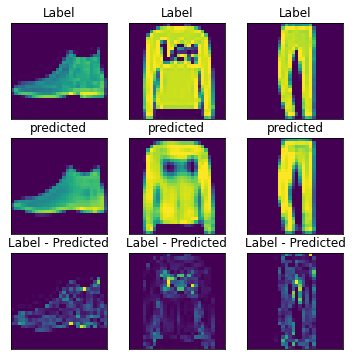

In [7]:
n = 3
plt.figure(figsize=(6, 6))
for i in range(n):

    # display original + noise
    ax = plt.subplot(3, n, i + 1)
    plt.title("Label")
    plt.imshow(tf.squeeze((test_images[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(3, n, i + n + 1)
    plt.title("predicted")
    plt.imshow(tf.squeeze((predicted_test[i]*255).astype('uint8')))
 #   plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 2*n + 1)
    plt.title("Label - Predicted")
    residual = np.squeeze(np.abs(test_images[i] - predicted_test[i]))
    residual = residual/residual.max()
    plt.imshow((residual*255).astype('uint8')) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [10]:
test_images[1].shape

(28, 28)

In [13]:
predicted_test[1].shape

(28, 28, 1)

In [8]:
psnr_pred = tf.image.psnr(predicted_test, test_images[:100], max_val=1.0)
print('PSNR: ', np.mean(psnr_pred))

PSNR:  21.912569


In [9]:
noise_factor_uniform = 0.4
noise_factor_normal = 0.25
noise_factor_speckle = 1.2

x_test_noisy_uniform = test_images + noise_factor_uniform * np.random.uniform(size=test_images.shape) 
x_test_noisy_normal = test_images + noise_factor_normal * np.random.normal(size=test_images.shape)
x_test_noisy_speckle = test_images + noise_factor_speckle * test_images * np.random.uniform(size=test_images.shape)


x_test_noisy_uniform = np.clip(x_test_noisy_uniform, 0., 1.)
x_test_noisy_normal = np.clip(x_test_noisy_normal, 0., 1.)
x_test_noisy_speckle = np.clip(x_test_noisy_speckle, 0., 1.)

In [11]:
predicted_uniform = autoencoder.predict(x_test_noisy_uniform[:100])
predicted_normal = autoencoder.predict(x_test_noisy_normal[:100])
predicted_speckle = autoencoder.predict(x_test_noisy_speckle[:100])

predicted_uniform = np.clip(predicted_uniform, 0., 1.)
predicted_normal = np.clip(predicted_normal, 0., 1.)
predicted_speckle = np.clip(predicted_speckle, 0., 1.)

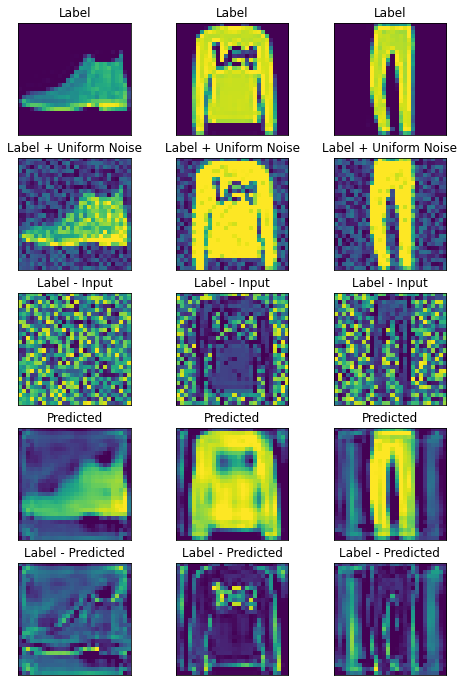

In [12]:
n = 3
plt.figure(figsize=(8, 12))
for i in range(n):

    # display original + noise
    ax = plt.subplot(5, n, i + 1)
    plt.title("Label")
    plt.imshow(tf.squeeze((test_images[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(5, n, i + n + 1)
    plt.title("Label + Uniform Noise")
    plt.imshow(tf.squeeze((x_test_noisy_uniform[i]*255).astype('uint8')))
 #   plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 2*n + 1)
    plt.title("Label - Input")
    residual_input = np.squeeze(np.abs(test_images[i] - x_test_noisy_uniform[i]))
    residual_input = residual_input/residual_input.max()
    plt.imshow((residual_input*255).astype('uint8')) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 3*n + 1)
    plt.title("Predicted")
    plt.imshow(tf.squeeze((predicted_uniform[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 4*n + 1)
    plt.title("Label - Predicted")
    residual = np.squeeze(np.abs(test_images[i] - predicted_uniform[i]))
    residual = residual/residual.max()
    plt.imshow((residual*255).astype('uint8'))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

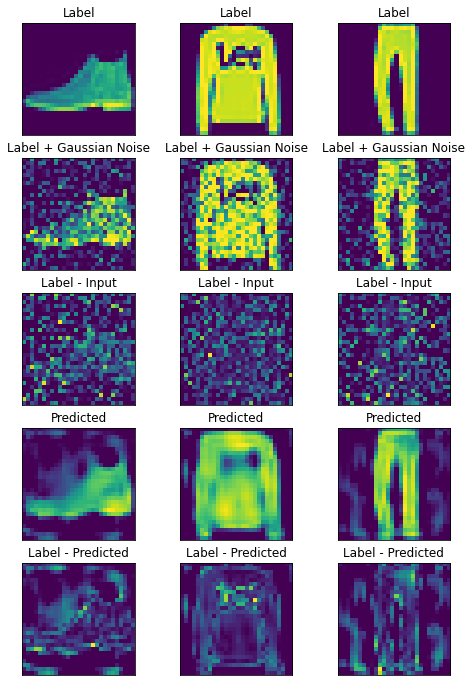

In [13]:
n = 3
plt.figure(figsize=(8, 12))
for i in range(n):

    # display original + noise
    ax = plt.subplot(5, n, i + 1)
    plt.title("Label")
    plt.imshow(tf.squeeze((test_images[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(5, n, i + n + 1)
    plt.title("Label + Gaussian Noise")
    plt.imshow(tf.squeeze((x_test_noisy_normal[i]*255).astype('uint8')))
 #   plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 2*n + 1)
    plt.title("Label - Input")
    residual_input = np.squeeze(np.abs(test_images[i] - x_test_noisy_normal[i]))
    residual_input = residual_input/residual_input.max()
    plt.imshow((residual_input*255).astype('uint8')) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 3*n + 1)
    plt.title("Predicted")
    plt.imshow(tf.squeeze((predicted_normal[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 4*n + 1)
    plt.title("Label - Predicted")
    residual = np.squeeze(np.abs(test_images[i] - predicted_normal[i]))
    residual = residual/residual.max()
    plt.imshow((residual*255).astype('uint8'))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

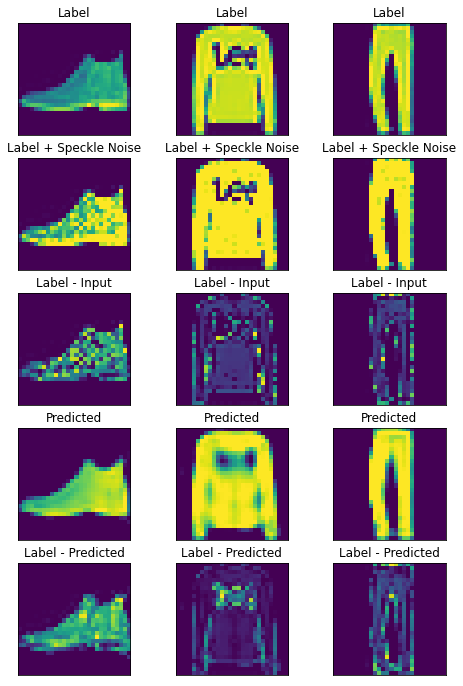

In [14]:
n = 3
plt.figure(figsize=(8, 12))
for i in range(n):

    # display original + noise
    ax = plt.subplot(5, n, i + 1)
    plt.title("Label")
    plt.imshow(tf.squeeze((test_images[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(5, n, i + n + 1)
    plt.title("Label + Speckle Noise")
    plt.imshow(tf.squeeze((x_test_noisy_speckle[i]*255).astype('uint8')))
 #   plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 2*n + 1)
    plt.title("Label - Input")
    residual_input = np.squeeze(np.abs(test_images[i] - x_test_noisy_speckle[i]))
    residual_input = residual_input/residual_input.max()
    plt.imshow((residual_input*255).astype('uint8')) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 3*n + 1)
    plt.title("Predicted")
    plt.imshow(tf.squeeze((predicted_speckle[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 4*n + 1)
    plt.title("Label - Predicted")
    residual = np.squeeze(np.abs(test_images[i] - predicted_speckle[i]))
    residual = residual/residual.max()
    plt.imshow((residual*255).astype('uint8'))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [15]:
psnr_uniform_pred = tf.image.psnr(predicted_uniform, test_images[:100], max_val=1.0)
psnr_uniform_input = tf.image.psnr(x_test_noisy_uniform[:100], test_images[:100], max_val=1.0)

psnr_normal_pred = tf.image.psnr(predicted_normal, test_images[:100], max_val=1.0)
psnr_normal_input = tf.image.psnr(x_test_noisy_normal[:100], test_images[:100], max_val=1.0)

psnr_speckle_pred = tf.image.psnr(predicted_speckle, test_images[:100], max_val=1.0)
psnr_speckle_input = tf.image.psnr(x_test_noisy_speckle[:100], test_images[:100], max_val=1.0)

print('Uniform: ', np.mean(psnr_uniform_input), np.mean(psnr_uniform_pred))
print('Gaussian: ', np.mean(psnr_normal_input), np.mean(psnr_normal_pred))
print('Speckle: ', np.mean(psnr_speckle_input), np.mean(psnr_speckle_pred))

Uniform:  13.559684 12.838811
Gaussian:  14.274091 17.338778
Speckle:  17.487978 17.163616


In [16]:
def calculate_PSNR(test_images,noise_factor_uniform,noise_factor_normal,noise_factor_speckle,autoencoder):
  x_test_noisy_uniform = test_images + noise_factor_uniform * np.random.uniform(size=test_images.shape) 
  x_test_noisy_normal = test_images + noise_factor_normal * np.random.normal(size=test_images.shape)
  x_test_noisy_speckle = test_images + noise_factor_speckle * test_images * np.random.uniform(size=test_images.shape)


  x_test_noisy_uniform = np.clip(x_test_noisy_uniform, 0., 1.)
  x_test_noisy_normal = np.clip(x_test_noisy_normal, 0., 1.)
  x_test_noisy_speckle = np.clip(x_test_noisy_speckle, 0., 1.)

  predicted_uniform = autoencoder.predict(x_test_noisy_uniform[:100])
  predicted_normal = autoencoder.predict(x_test_noisy_normal[:100])
  predicted_speckle = autoencoder.predict(x_test_noisy_speckle[:100])

  predicted_uniform = np.clip(predicted_uniform, 0., 1.)
  predicted_normal = np.clip(predicted_normal, 0., 1.)
  predicted_speckle = np.clip(predicted_speckle, 0., 1.)

  psnr_uniform_pred = tf.image.psnr(predicted_uniform, test_images[:100], max_val=1.0)
  psnr_uniform_input = tf.image.psnr(x_test_noisy_uniform[:100], test_images[:100], max_val=1.0)

  psnr_normal_pred = tf.image.psnr(predicted_normal, test_images[:100], max_val=1.0)
  psnr_normal_input = tf.image.psnr(x_test_noisy_normal[:100], test_images[:100], max_val=1.0)

  psnr_speckle_pred = tf.image.psnr(predicted_speckle, test_images[:100], max_val=1.0)
  psnr_speckle_input = tf.image.psnr(x_test_noisy_speckle[:100], test_images[:100], max_val=1.0)

  print('Uniform: ', np.mean(psnr_uniform_input), np.mean(psnr_uniform_pred))
  print('Gaussian: ', np.mean(psnr_normal_input), np.mean(psnr_normal_pred))
  print('Speckle: ', np.mean(psnr_speckle_input), np.mean(psnr_speckle_pred))

  return np.mean(psnr_uniform_input), np.mean(psnr_uniform_pred), np.mean(psnr_normal_input), np.mean(psnr_normal_pred), np.mean(psnr_speckle_input), np.mean(psnr_speckle_pred)

In [17]:
# print('----')
# noise_factor_uniform = 0.74
# noise_factor_normal = 0.5
# noise_factor_speckle = 2.8
# calculate_PSNR(test_images,noise_factor_uniform,noise_factor_normal,noise_factor_speckle,autoencoder)
PSNR_Results = []
for i in range(0,20):
  noise_factor_uniform = i*0.04
  noise_factor_normal = i*0.025
  noise_factor_speckle = i*0.12
  PSNR_Results.append(calculate_PSNR(test_images,noise_factor_uniform,noise_factor_normal,noise_factor_speckle,autoencoder))
  print('----')

PSNR_Results = np.asarray(PSNR_Results)

Uniform:  inf 21.912569
Gaussian:  inf 21.912569
Speckle:  inf 21.912569
----
Uniform:  32.81619 21.59274
Gaussian:  33.47619 21.832941
Speckle:  31.526567 21.504566
----
Uniform:  26.812708 20.769726
Gaussian:  27.473164 21.550194
Speckle:  26.222176 20.705399
----
Uniform:  23.371 19.553566
Gaussian:  24.041939 21.163654
Speckle:  23.478333 19.972502
----
Uniform:  20.959496 18.533741
Gaussian:  21.604753 20.675747
Speckle:  21.841442 19.371004
----
Uniform:  19.101393 17.381462
Gaussian:  19.788603 20.18179
Speckle:  20.59451 18.843271
----
Uniform:  17.59456 16.180052
Gaussian:  18.314323 19.633589
Speckle:  19.7424 18.453686
----
Uniform:  16.3382 15.108842
Gaussian:  17.080008 19.069918
Speckle:  18.99458 18.063068
----
Uniform:  15.265843 14.237118
Gaussian:  16.036888 18.519293
Speckle:  18.425238 17.745743
----
Uniform:  14.3692045 13.483306
Gaussian:  15.082659 17.877037
Speckle:  17.871052 17.4179
----
Uniform:  13.547825 12.855145
Gaussian:  14.260438 17.317358
Speckle:  17

In [18]:
from scipy.io import savemat

savemat('Noisy_AE_PSNR_Results.mat',{'PSNR_Results':PSNR_Results})

from google.colab import files
files.download("Noisy_AE_PSNR_Results.mat")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>